In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [64]:
plt.rcParams.update({'font.size': 20})

In [4]:
df = pd.read_csv("/home/mzo5929/Keerthana/grnInference/real_data/wheat_2020_single_molecule/KCA.csv")

In [3]:
#Identify sister cells - they have to be in same colony and have identical tdiv
df

,experiment,colonyID,CellID,tdiv,pu1,p1TS,pu1nas,gata2,g2TS,g2nas,gata1,g1TS,g1nas,State
0,1,3,18.0,23.750000,65,0,0.00000,14,0,0.00000,2,0,0.0,Low
1,1,3,19.0,23.750000,36,0,0.00000,77,0,0.00000,1,0,0.0,G2H
2,1,3,22.0,11.000000,41,0,0.00000,33,1,7.85863,5,0,0.0,Low
3,1,3,23.0,11.000000,29,1,2.04643,112,1,13.02810,2,0,0.0,G2H
4,1,3,24.0,19.750000,31,0,0.00000,122,2,24.70733,6,0,0.0,G2H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,2,533,164.0,0.000000,7,0,0.00000,14,0,0.00000,1,0,0.0,Low
1951,2,533,165.0,0.000000,7,0,0.00000,30,0,0.00000,1,0,0.0,Low
1952,2,533,176.0,3.583333,0,1,2.49458,54,0,0.00000,0,0,0.0,Low
1953,2,533,177.0,3.500000,7,0,0.00000,24,0,0.00000,1,0,0.0,Low


In [11]:
# Identify sister cells: same colony and same tdiv
sisters = df.groupby(['colonyID', 'tdiv']).filter(lambda x: len(x) > 1)

# Create sister pairs
sister_pairs = (
    sisters.groupby(['colonyID', 'tdiv'])
    .apply(lambda x: [(row1.CellID, row2.CellID) 
                      for i, row1 in x.iterrows() 
                      for j, row2 in x.iterrows() if i < j])
    .explode()
    .dropna()
    .tolist()
)

# Extract pu1, gata1, gata2 values for these pairs
pairs_data = []
for cell1, cell2 in sister_pairs:
    c1 = df[df['CellID'] == cell1][['pu1', 'gata1', 'gata2', 'tdiv']].iloc[0]
    c2 = df[df['CellID'] == cell2][['pu1', 'gata1', 'gata2', 'tdiv']].iloc[0]
    pairs_data.append({
        'cell1': cell1, 'cell2': cell2, 't_div':c1.tdiv,
        'pu1_cell1': c1.pu1, 'gata1_cell1': c1.gata1, 'gata2_cell1': c1.gata2,
        'pu1_cell2': c2.pu1, 'gata1_cell2': c2.gata1, 'gata2_cell2': c2.gata2
    })

pairs_df = pd.DataFrame(pairs_data)



/tmp/ipykernel_581625/541049931.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(row1.CellID, row2.CellID)


In [12]:
pairs_df

,cell1,cell2,t_div,pu1_cell1,gata1_cell1,gata2_cell1,pu1_cell2,gata1_cell2,gata2_cell2
0,34.0,35.0,0.00,46.0,1.0,25.0,36.0,2.0,28.0
1,34.0,50.0,0.00,46.0,1.0,25.0,15.0,7.0,87.0
2,34.0,51.0,0.00,46.0,1.0,25.0,8.0,6.0,86.0
3,35.0,50.0,0.00,36.0,2.0,28.0,15.0,7.0,87.0
4,35.0,51.0,0.00,36.0,2.0,28.0,8.0,6.0,86.0
...,...,...,...,...,...,...,...,...,...
1074,83.0,87.0,0.00,51.0,1.0,6.0,28.0,3.0,18.0
1075,83.0,87.0,0.00,51.0,1.0,6.0,28.0,3.0,18.0
1076,86.0,87.0,5.25,21.0,1.0,30.0,28.0,3.0,18.0
1077,86.0,87.0,5.25,21.0,1.0,30.0,28.0,3.0,18.0


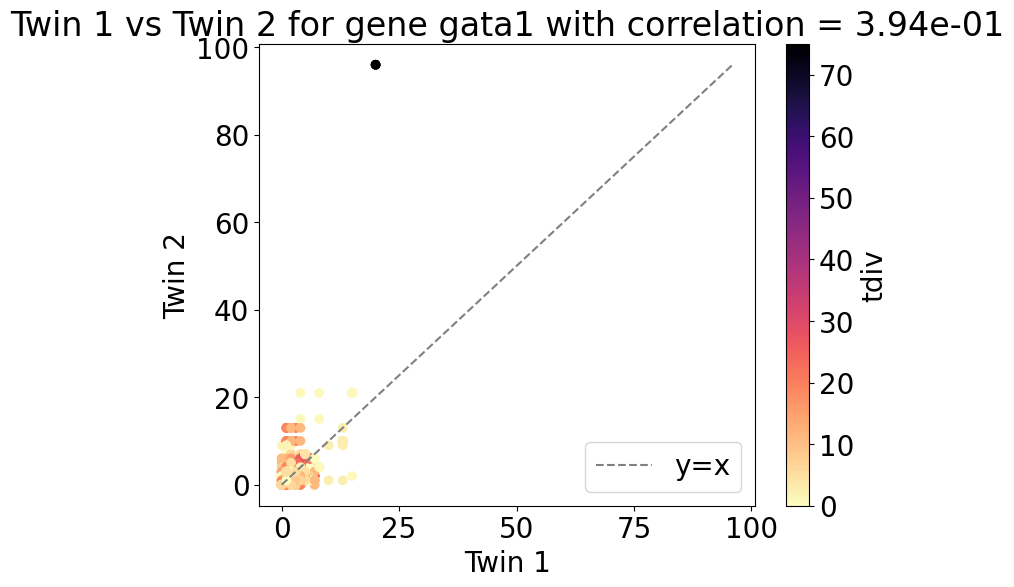

In [67]:
gene = "gata1"
plt.figure(figsize=(8, 6))
plt.scatter(
    pairs_df[f"{gene}_cell1"],
    pairs_df[f"{gene}_cell2"],
    c=pairs_df["t_div"],
    cmap="magma_r"
)
plt.xlabel("Twin 1")
plt.ylabel("Twin 2")
x = np.linspace(min(pairs_df[f"{gene}_cell1"].min(), pairs_df[f"{gene}_cell2"].min()), 
                max(pairs_df[f"{gene}_cell1"].max(), pairs_df[f"{gene}_cell2"].max()), 100)
y = x
plt.plot(x, y, color='gray', linestyle='--', label='y=x')
plt.legend()
# END: Add x=y line
corr, _ = spearmanr(pairs_df[f"{gene}_cell1"], pairs_df[f"{gene}_cell2"])
plt.title(f"Twin 1 vs Twin 2 for gene {gene} with correlation = {corr:.2e}")
plt.colorbar(label="tdiv")
plt.show()

In [18]:
df

,experiment,colonyID,CellID,tdiv,pu1,p1TS,pu1nas,gata2,g2TS,g2nas,gata1,g1TS,g1nas,State
0,1,3,18.0,23.750000,65,0,0.00000,14,0,0.00000,2,0,0.0,Low
1,1,3,19.0,23.750000,36,0,0.00000,77,0,0.00000,1,0,0.0,G2H
2,1,3,22.0,11.000000,41,0,0.00000,33,1,7.85863,5,0,0.0,Low
3,1,3,23.0,11.000000,29,1,2.04643,112,1,13.02810,2,0,0.0,G2H
4,1,3,24.0,19.750000,31,0,0.00000,122,2,24.70733,6,0,0.0,G2H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,2,533,164.0,0.000000,7,0,0.00000,14,0,0.00000,1,0,0.0,Low
1951,2,533,165.0,0.000000,7,0,0.00000,30,0,0.00000,1,0,0.0,Low
1952,2,533,176.0,3.583333,0,1,2.49458,54,0,0.00000,0,0,0.0,Low
1953,2,533,177.0,3.500000,7,0,0.00000,24,0,0.00000,1,0,0.0,Low


Spearman correlation between pu1 and gata1: 0.04570351445157647
Spearman correlation between pu1 and gata2: -0.19235072089876964
Spearman correlation between gata1 and gata2: 0.37180819164906276


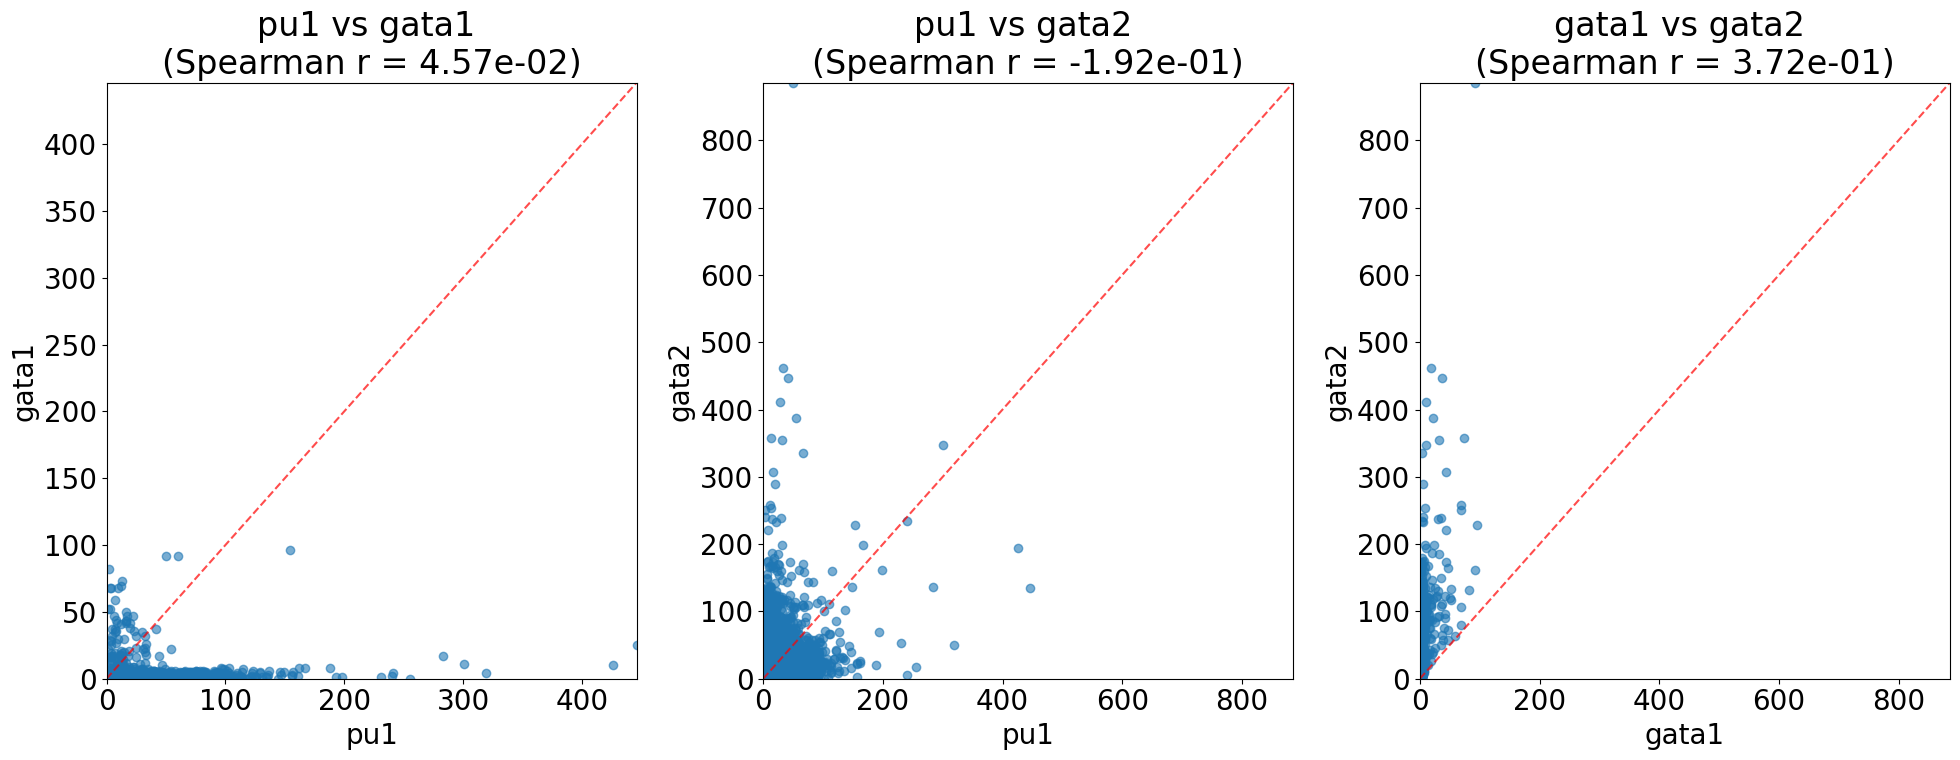

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

pu1_gata1 = spearmanr(df['pu1'], df['gata1'])
pu1_gata2 = spearmanr(df['pu1'], df['gata2'])
gata1_gata2 = spearmanr(df['gata1'], df['gata2'])

print("Spearman correlation between pu1 and gata1:", pu1_gata1.correlation)
print("Spearman correlation between pu1 and gata2:", pu1_gata2.correlation)
print("Spearman correlation between gata1 and gata2:", gata1_gata2.correlation)

# Helper to add x=y line
def add_xy_line(ax, x, y):
    lims = [
        min(x.min(), y.min()),
        max(x.max(), y.max())
    ]
    ax.plot(lims, lims, 'r--', alpha=0.7)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

# Plot 1: pu1 vs gata1
axes[0].scatter(df['pu1'], df['gata1'], alpha=0.6)
add_xy_line(axes[0], df['pu1'], df['gata1'])
axes[0].set_xlabel("pu1")
axes[0].set_ylabel("gata1")
axes[0].set_title(f"pu1 vs gata1 \n(Spearman r = {pu1_gata1.correlation:.2e})")

# Plot 2: pu1 vs gata2
axes[1].scatter(df['pu1'], df['gata2'], alpha=0.6)
add_xy_line(axes[1], df['pu1'], df['gata2'])
axes[1].set_xlabel("pu1")
axes[1].set_ylabel("gata2")
axes[1].set_title(f"pu1 vs gata2 \n(Spearman r = {pu1_gata2.correlation:.2e})")

# Plot 3: gata1 vs gata2
axes[2].scatter(df['gata1'], df['gata2'], alpha=0.6)
add_xy_line(axes[2], df['gata1'], df['gata2'])
axes[2].set_xlabel("gata1")
axes[2].set_ylabel("gata2")
axes[2].set_title(f"gata1 vs gata2 \n(Spearman r = {gata1_gata2.correlation:.2e})")

plt.tight_layout()
plt.show()


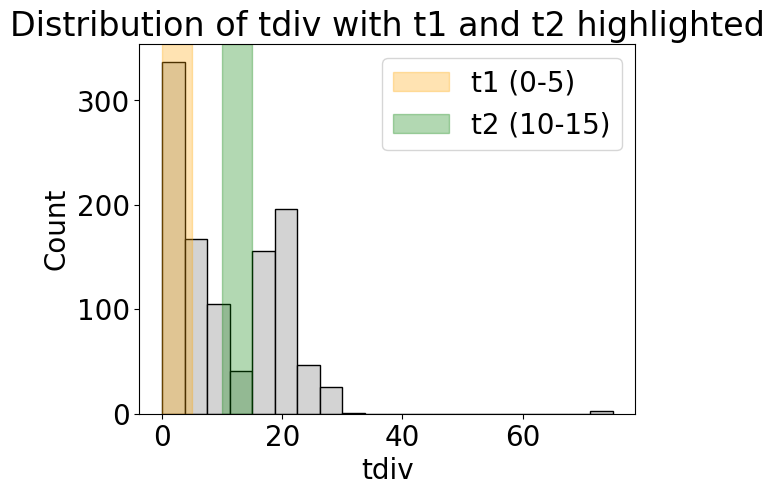

In [91]:
# Plot histogram
plt.hist(pairs_df['t_div'], bins=20, edgecolor='black', color='lightgray')

# Add vertical shaded regions for t1 and t2
plt.axvspan(0, 5, color='orange', alpha=0.3, label='t1 (0-5)')
plt.axvspan(10, 15, color='green', alpha=0.3, label='t2 (10-15)')

plt.xlabel("tdiv")
plt.ylabel("Count")
plt.title("Distribution of tdiv with t1 and t2 highlighted")
plt.legend()
plt.show()


In [79]:
# Twin correlations at time t1
twin_t1 = pairs_df[pairs_df['t_div'] < 5].copy() 
print(f"Number of pairs = {len(twin_t1)}")
# Calculate the differences for pu1 and gata1
twin_t1['pu1_diff'] = np.log2(1 + twin_t1['pu1_cell1']) - np.log2(1 + twin_t1['pu1_cell2'])#twin_t1['pu1_cell1'] - twin_t1['pu1_cell2']
twin_t1['gata1_diff'] = np.log2(1 + twin_t1['gata1_cell1']) - np.log2(1 + twin_t1['gata1_cell2'])#twin_t1['gata1_cell1'] - twin_t1['gata1_cell2']
twin_t1['gata2_diff'] = np.log2(1 + twin_t1['gata2_cell1']) - np.log2(1 + twin_t1['gata2_cell2'])#twin_t1['gata2_cell1'] - twin_t1['gata2_cell2']

# Calculate Spearman correlations for the differences
pu1_gata1_twin_t1 = spearmanr(twin_t1['pu1_diff'], twin_t1['gata1_diff'])
pu1_gata2_twin_t1 = spearmanr(twin_t1['pu1_diff'], twin_t1['gata2_diff'])
gata1_gata2_twin_t1 = spearmanr(twin_t1['gata1_diff'], twin_t1['gata2_diff'])

print("Spearman correlation for pu1 and gata1 differences:", pu1_gata1_twin_t1.correlation)
print("Spearman correlation for pu1 and gata2 differences:", pu1_gata2_twin_t1.correlation)
print("Spearman correlation for gata1 and gata2 differences:", gata1_gata2_twin_t1.correlation)

Number of pairs = 402
Spearman correlation for pu1 and gata1 differences: -0.041639705230997255
Spearman correlation for pu1 and gata2 differences: -0.22829055844447058
Spearman correlation for gata1 and gata2 differences: 0.22888896258809352


In [84]:
# Twin correlations at time t1
twin_t1 = pairs_df[pairs_df['t_div'] < 5].copy() 
print(f"Number of pairs = {len(twin_t1)}")
# Calculate the differences for pu1 and gata1
twin_t1['pu1_diff'] = twin_t1['pu1_cell1'] - twin_t1['pu1_cell2']
twin_t1['gata1_diff'] = twin_t1['gata1_cell1'] - twin_t1['gata1_cell2']
twin_t1['gata2_diff'] = twin_t1['gata2_cell1'] - twin_t1['gata2_cell2']

# Calculate Spearman correlations for the differences
pu1_gata1_twin_t1 = spearmanr(twin_t1['pu1_diff'], twin_t1['gata1_diff'])
pu1_gata2_twin_t1 = spearmanr(twin_t1['pu1_diff'], twin_t1['gata2_diff'])
gata1_gata2_twin_t1 = spearmanr(twin_t1['gata1_diff'], twin_t1['gata2_diff'])

print("Spearman correlation for pu1 and gata1 differences:", pu1_gata1_twin_t1.correlation)
print("Spearman correlation for pu1 and gata2 differences:", pu1_gata2_twin_t1.correlation)
print("Spearman correlation for gata1 and gata2 differences:", gata1_gata2_twin_t1.correlation)

Number of pairs = 402
Spearman correlation for pu1 and gata1 differences: -0.15915010715297448
Spearman correlation for pu1 and gata2 differences: -0.37880571863847834
Spearman correlation for gata1 and gata2 differences: 0.2915752675569337


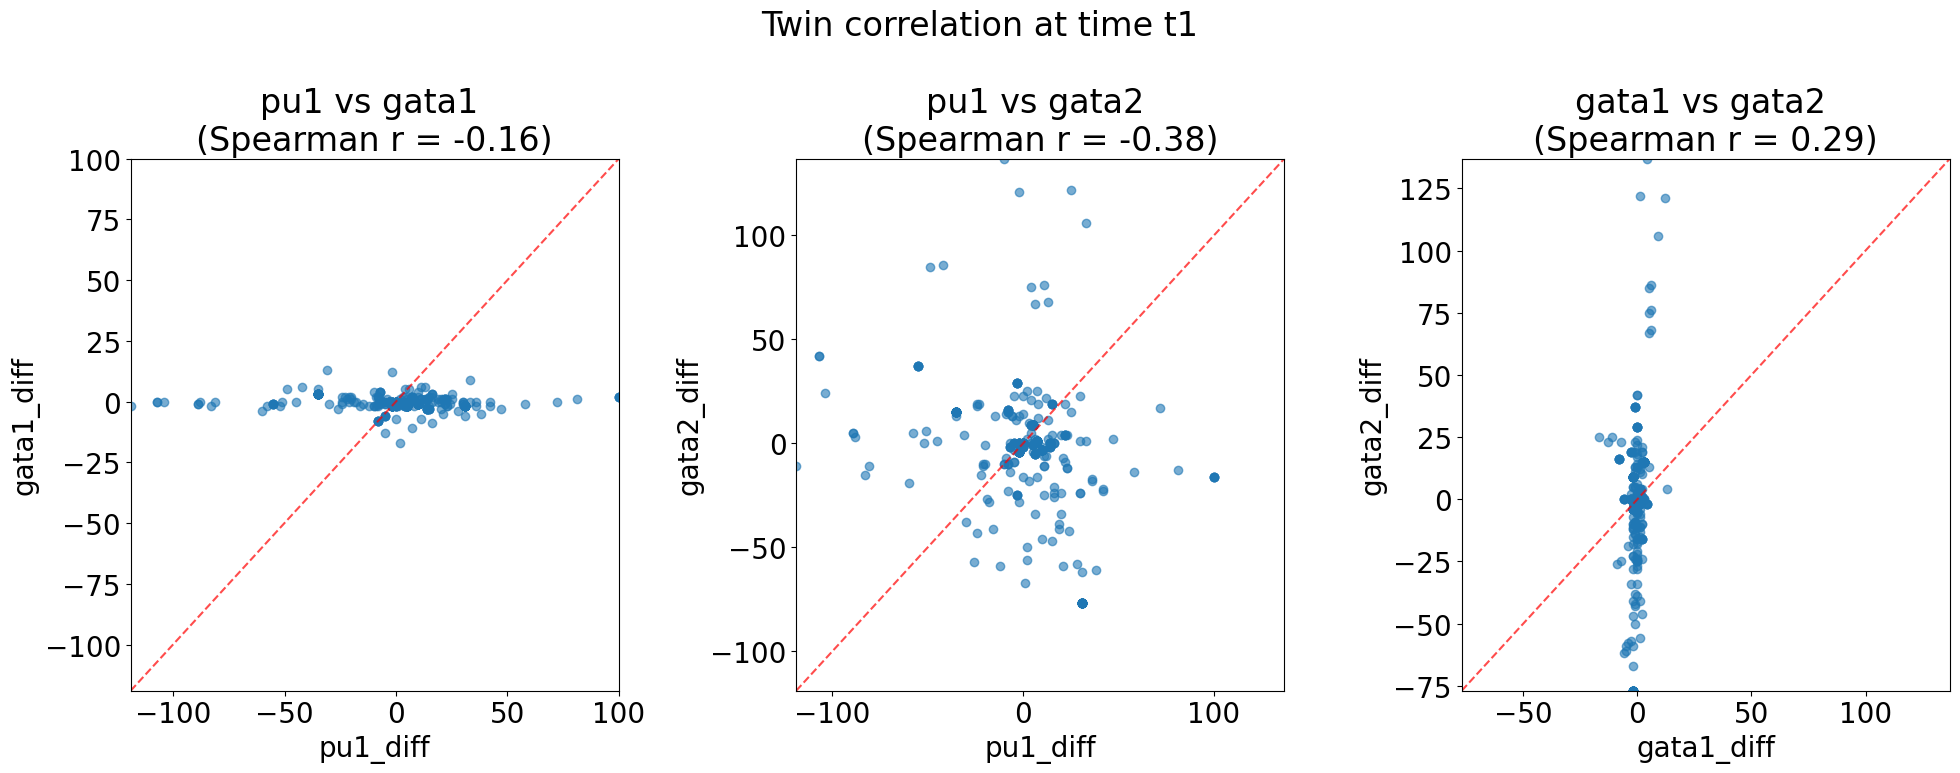

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Twin correlation at time t1")
# Plot 1: pu1_diff vs gata1_diff
axes[0].scatter(twin_t1['pu1_diff'], twin_t1['gata1_diff'], alpha=0.6)
add_xy_line(axes[0], twin_t1['pu1_diff'], twin_t1['gata1_diff'])
axes[0].set_xlabel("pu1_diff")
axes[0].set_ylabel("gata1_diff")
axes[0].set_title(f"pu1 vs gata1 \n(Spearman r = {pu1_gata1_twin_t1.correlation:.2f})")

# Plot 2: pu1_diff vs gata2_diff
axes[1].scatter(twin_t1['pu1_diff'], twin_t1['gata2_diff'], alpha=0.6)
add_xy_line(axes[1], twin_t1['pu1_diff'], twin_t1['gata2_diff'])
axes[1].set_xlabel("pu1_diff")
axes[1].set_ylabel("gata2_diff")
axes[1].set_title(f"pu1 vs gata2 \n(Spearman r = {pu1_gata2_twin_t1.correlation:.2f})")

# Plot 3: gata1_diff vs gata2_diff
axes[2].scatter(twin_t1['gata1_diff'], twin_t1['gata2_diff'], alpha=0.6)
add_xy_line(axes[2], twin_t1['gata1_diff'], twin_t1['gata2_diff'])
axes[2].set_xlabel("gata1_diff")
axes[2].set_ylabel("gata2_diff")
axes[2].set_title(f"gata1 vs gata2 \n(Spearman r = {gata1_gata2_twin_t1.correlation:.2f})")

plt.tight_layout()
plt.show()


In [92]:
# Twin correlations at time t1
twin_t2 = pairs_df[(pairs_df['t_div'] >= 10) & (pairs_df['t_div'] < 20)].copy()  # ✅ Use .copy()
print(f"Number of pairs = {len(twin_t2)}")
# Calculate the differences for pu1 and gata1
twin_t2['pu1_diff'] = np.log2(1 + twin_t2['pu1_cell1']) - np.log2(1 + twin_t2['pu1_cell2'])#twin_t2['pu1_cell1'] - twin_t2['pu1_cell2']
twin_t2['gata1_diff'] = np.log2(1 + twin_t2['gata1_cell1']) - np.log2(1 + twin_t2['gata1_cell2'])#twin_t2['gata1_cell1'] - twin_t2['gata1_cell2']
twin_t2['gata2_diff'] = np.log2(1 + twin_t2['gata2_cell1']) - np.log2(1 + twin_t2['gata2_cell2'])#twin_t2['gata2_cell1'] - twin_t2['gata2_cell2']

# Calculate Spearman correlations for the differences
pu1_gata1_twin_t2 = spearmanr(twin_t2['pu1_diff'], twin_t2['gata1_diff'])
pu1_gata2_twin_t2 = spearmanr(twin_t2['pu1_diff'], twin_t2['gata2_diff'])
gata1_gata2_twin_t2 = spearmanr(twin_t2['gata1_diff'], twin_t2['gata2_diff'])

print("Spearman correlation for pu1 and gata1 differences:", pu1_gata1_twin_t2.correlation)
print("Spearman correlation for pu1 and gata2 differences:", pu1_gata2_twin_t2.correlation)
print("Spearman correlation for gata1 and gata2 differences:", gata1_gata2_twin_t2.correlation)

Number of pairs = 432
Spearman correlation for pu1 and gata1 differences: 0.29363257163741907
Spearman correlation for pu1 and gata2 differences: -0.005444572595229479
Spearman correlation for gata1 and gata2 differences: 0.1393140238246502


In [95]:
# Twin correlations at time t1
twin_t2 = pairs_df[(pairs_df['t_div'] >= 10) & (pairs_df['t_div'] < 20)].copy()  # ✅ Use .copy()
print(f"Number of pairs = {len(twin_t2)}")
# Calculate the differences for pu1 and gata1
twin_t2['pu1_diff'] = twin_t2['pu1_cell1'] - twin_t2['pu1_cell2']
twin_t2['gata1_diff'] = twin_t2['gata1_cell1'] - twin_t2['gata1_cell2']
twin_t2['gata2_diff'] = twin_t2['gata2_cell1'] - twin_t2['gata2_cell2']

# Calculate Spearman correlations for the differences
pu1_gata1_twin_t2 = spearmanr(twin_t2['pu1_diff'], twin_t2['gata1_diff'])
pu1_gata2_twin_t2 = spearmanr(twin_t2['pu1_diff'], twin_t2['gata2_diff'])
gata1_gata2_twin_t2 = spearmanr(twin_t2['gata1_diff'], twin_t2['gata2_diff'])

print("Spearman correlation for pu1 and gata1 differences:", pu1_gata1_twin_t2.correlation)
print("Spearman correlation for pu1 and gata2 differences:", pu1_gata2_twin_t2.correlation)
print("Spearman correlation for gata1 and gata2 differences:", gata1_gata2_twin_t2.correlation)

Number of pairs = 432
Spearman correlation for pu1 and gata1 differences: 0.31629392458347355
Spearman correlation for pu1 and gata2 differences: -0.06164728288066117
Spearman correlation for gata1 and gata2 differences: 0.074070090564398


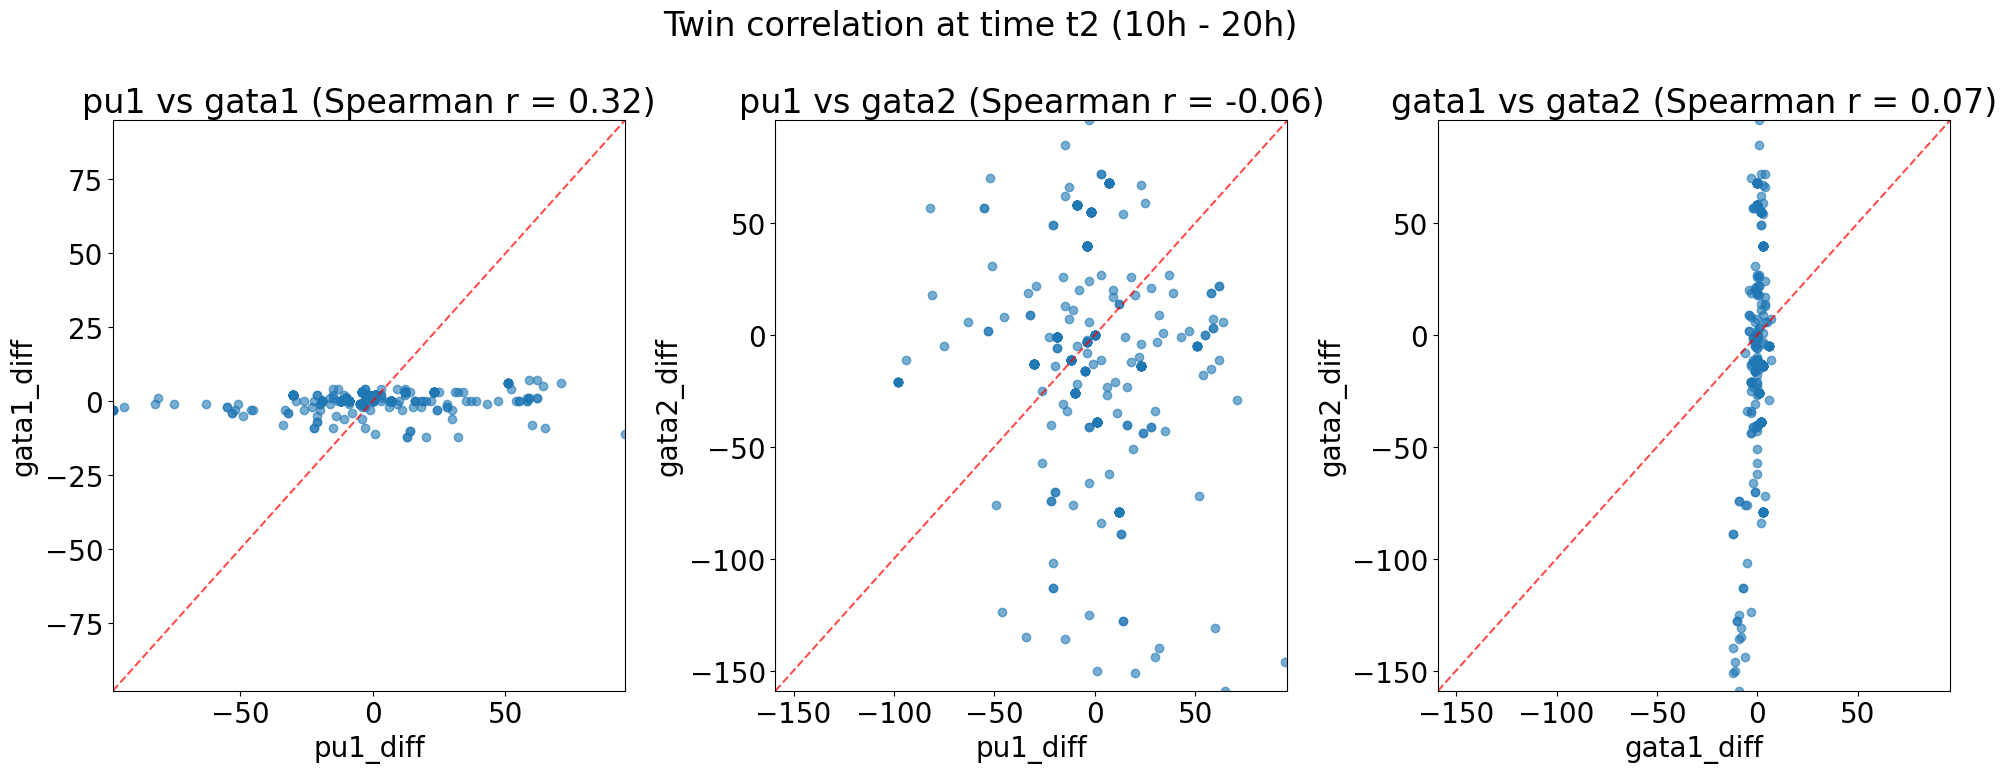

In [99]:
# Plotting for tdiv between 10 and 20
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Twin correlation at time t2 (10h - 20h)")
axes[0].scatter(twin_t2['pu1_diff'], twin_t2['gata1_diff'], alpha=0.6)
add_xy_line(axes[0], twin_t2['pu1_diff'], twin_t2['gata1_diff'])
axes[0].set_xlabel("pu1_diff")
axes[0].set_ylabel("gata1_diff")
axes[0].set_title(f"pu1 vs gata1 (Spearman r = {pu1_gata1_twin_t2.correlation:.2f})")

axes[1].scatter(twin_t2['pu1_diff'], twin_t2['gata2_diff'], alpha=0.6)
add_xy_line(axes[1], twin_t2['pu1_diff'], twin_t2['gata2_diff'])
axes[1].set_xlabel("pu1_diff")
axes[1].set_ylabel("gata2_diff")
axes[1].set_title(f"pu1 vs gata2 (Spearman r = {pu1_gata2_twin_t2.correlation:.2f})")

axes[2].scatter(twin_t2['gata1_diff'], twin_t2['gata2_diff'], alpha=0.6)
add_xy_line(axes[2], twin_t2['gata1_diff'], twin_t2['gata2_diff'])
axes[2].set_xlabel("gata1_diff")
axes[2].set_ylabel("gata2_diff")
axes[2].set_title(f"gata1 vs gata2 (Spearman r = {gata1_gata2_twin_t2.correlation:.2f})")

plt.tight_layout()
plt.show()


Pairs in t1: 547 Pairs in t2: 528


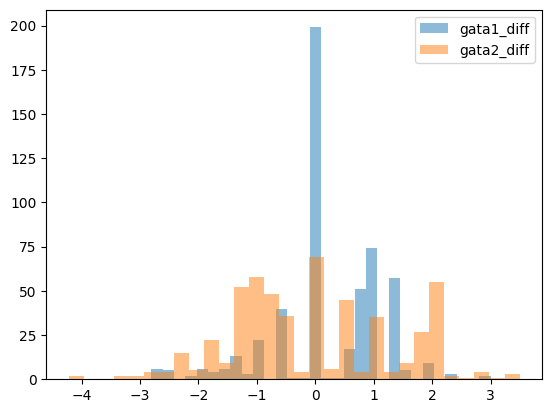

In [61]:
print("Pairs in t1:", len(twin_t1), "Pairs in t2:", len(twin_t2))
plt.hist(twin_t2['gata1_diff'], bins=30, alpha=0.5, label='gata1_diff')
plt.hist(twin_t2['gata2_diff'], bins=30, alpha=0.5, label='gata2_diff')
plt.legend(); plt.show()
